https://www.kaggle.com/wesamelshamy/trackml-problem-explanation-and-data-exploration

# Quick Problem Description
Link every *track* to one *hit*.

*Disclaimer: over simplifying physics to understand this problem*.

Every particle leaves a track behind it.  Like a car leaving tyre marks in the sand.  We did not catch the particle in action.  Now we want to link every track (tyre marks) to one hit that the particle created.

In every **event**, a large number of **particles** are released.  They move along a path leaving behind their **tracks**.  They eventually **hit** a particle detector surface on the other end.

In the training data we have the following information on each **event**:
- **Hits**: $x, y, z$ coordinates of each hit on the particle detector.
- **Particles**: Each particle's initial position ($v_x, v_y, v_z$), momentum ($p_x, p_y, p_z$), charge ($q$) and number of hits.
- **Truth**: Mapping between hits and generating particles.  The particle's trajectory, momentum and the hit weight.
- **Cells**: Precise location of where the particle hit the detector and how much energy it deposited.

In [16]:
import os

import numpy as np
import pandas as pd

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [17]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('../input/train_1', event_prefix))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001000 memory usage 18.46 MB


## Hits Data

### Where Did it Hit?
Here we have the  x,y,z  global coordinates (in millimeters) of where the particles hit the detector surface.

### hits columns

The hits file contains the following values for each hit/entry:  

hit_id: numerical identifier of the hit inside the event.  
x, y, z: measured x, y, z position (in millimeter) of the hit in global coordinates.  
volume_id: numerical identifier of the detector group.  
layer_id: numerical identifier of the detector layer inside the group.  
module_id: numerical identifier of the detector module inside the layer.  

ヒットファイルには、ヒット/エントリごとに次の値が含まれます。  

hit_id：イベント内のヒットの数値ID。  
x、y、z：グローバル座標におけるヒットの測定されたx、y、z位置（ミリメートル）。  
volume_id：検出器グループの数値識別子。  
layer_id：グループ内の検出器層の数値識別子。  
module_id：層内の検出器モジュールの数値識別子。  

![](https://cernbox.cern.ch/index.php/s/Kl5TgmatSQ9mYjk/download)
 
 
 ボリューム/層/モジュールIDは原則としてx、y、zから導き出すことができる。検出器特有のデータ処理を簡略化するためにここに示します。

In [18]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [19]:
hits.tail()

,hit_id,x,y,z,volume_id,layer_id,module_id
120934,120935,-763.862976,51.569401,2944.5,18,12,97
120935,120936,-808.705017,3.459260,2944.5,18,12,97
120936,120937,-982.935974,41.460899,2952.5,18,12,98
120937,120938,-942.698975,18.489100,2952.5,18,12,98
120938,120939,-922.890015,2.092850,2952.5,18,12,98


In [20]:
hits.shape

(120939, 7)

Here is the distribution of $x, y, z$ location of hits in event 1000.  This is only for one out of 8,850 events.

### Vertical Intersection ($x, y$) in Detection Layers
As shown in the figure below, the hits are semi evenly distributed on the detector surface $x, y$.  The white circle in the center of the plot is where the beam pipe lies.  Thanks [agerom] for [the clarification][clar].

The colors represent different detector volumes.  Thanks to [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc
[clar]: https://www.kaggle.com/wesamelshamy/trackml-problem-explanation-and-data-exploration/comments#323803
[agerom]: https://www.kaggle.com/artemiosgeromitsos

### 検出レイヤーにおける水平交差（$ y、z $）
下のグラフは、すべての点がヒットしている検出面の水平な交差点と考えることができます。 この表のさまざまな活動レベルと上記の$ x、y $の関係を確認してください。

異なる色は、検出器表面の異なる体積を表す。

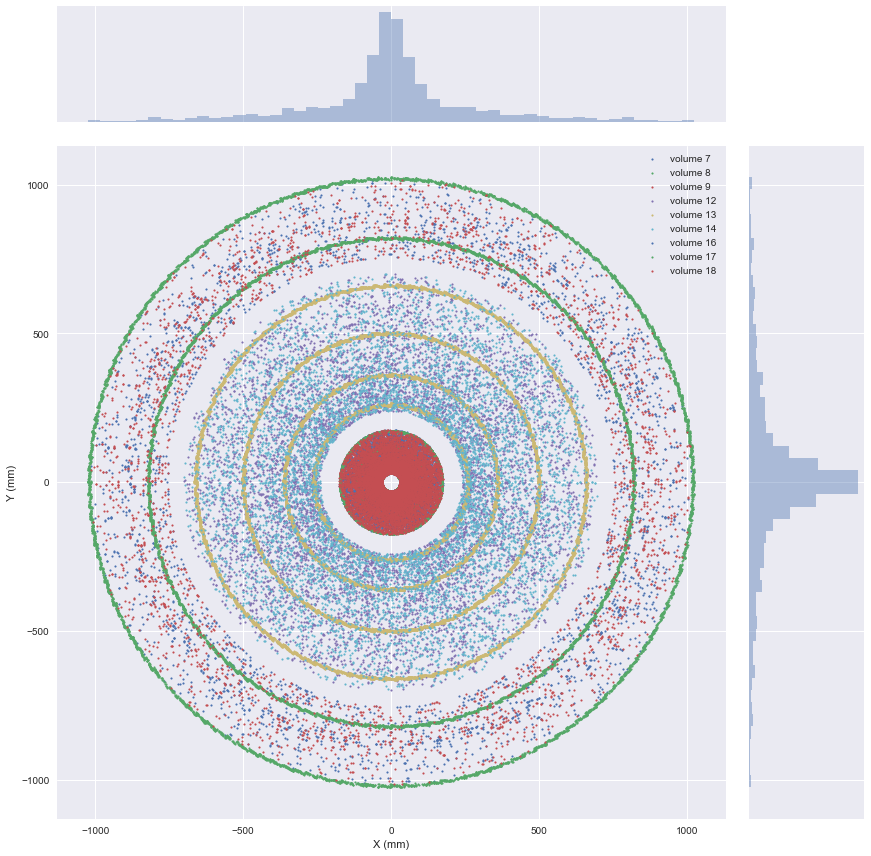

In [21]:
g = sns.jointplot(hits.x, hits.y,  s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()


And here is how the hits in this event look like in 3D.  Again, a smaple from one event.  This combiles the previous two charts in 3D.

Notice how the particles penetrate the detector surface along $z$ coordinate.

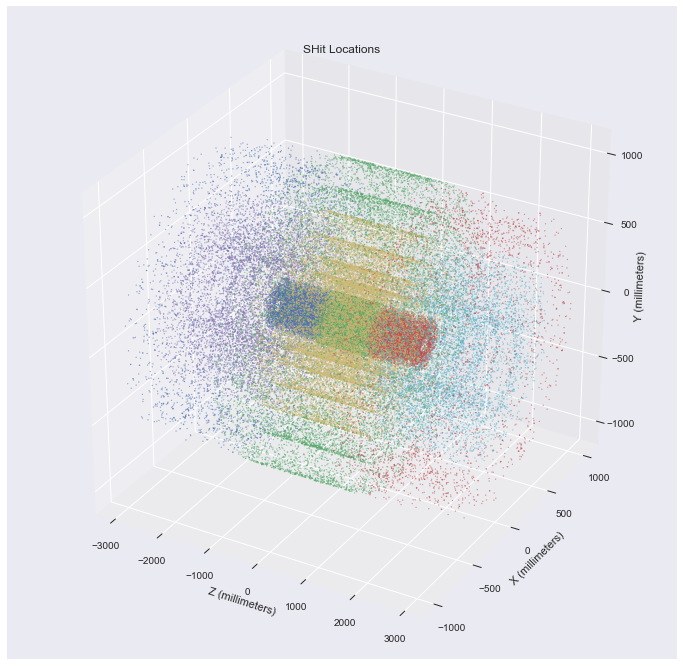

In [22]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('SHit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()

### Affected Surface Object
The **volume**, **layer** and **module** are nested parts on the detector surface.  The volume, is made of layers, which in turn have modules.  Analyzing their response could help us understand if some of them are dead/defective and therefore we may need to account for the bias they cause.

The figure below shows a plot of every combination of `x`, `y`, `volume`, `layer` and `module`.  The colors identify different *volumes*.  Along the main diagonal we have the variables' historgrams.

The (`hit_id`, `x`) and (`hit_id`, `y`) pairs show us how different volumes are layered.

This figure idea is taken from [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc

### 影響を受けるサーフェイスオブジェクト
**体積**、**層**および**モジュール**は、検出器表面上の入れ子部分です。 音量はレイヤーで構成され、レイヤーにはモジュールがあります。 彼らの反応を分析することは、それらのうちのいくつかが死んでいるか欠陥であるかを理解するのに役立ち、したがって、彼らが引き起こすバイアスを説明する必要があるかもしれない。

下の図は `x`、` y`、 `volume`、` layer`と `module`のすべての組み合わせのプロットを示しています。 色は異なる*ボリュームを識別します*。 主対角線に沿って、変数 'historgramsを持っています。

（ `hit_id`、` x`）と（ `hit_id`、` y`）のペアは、どのように異なるボリュームが階層化されているかを示しています。

この図のアイデアは[ジョシュアボナットのノート] [ジョシュ]から取られています。

[josh]：https://www.kaggle.com/jbonatt/trackml-eda-etc

In [23]:
hits_sample = hits.sample(8000)
sns.pairplot(hits_sample, hue='volume_id', size=8)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Particles' Data
The particles data help us understand the particles intitial position, momentum and charge which we can join with the event truth data set to get the particles final position and momentum.  This is needed to identify the tracks that the particle generated.

Here is how the data look like:

## パーティクルのデータ
パーティクルデータは、パーティクルの最終的な位置と運動量を得るために設定されたイベント真理値データと結合できるパーティクルの初期位置、運動量、および電荷を理解するのに役立ちます。 これは、パーティクルが生成したトラックを識別するために必要です。

データの外観は次のとおりです。


パーティクルファイルには、各パーティクル/エントリの次の値が含まれています。  

particle_id：イベント内のパーティクルの数値ID。  
vx、vy、vz：グローバル座標の初期位置または頂点（ミリメートル）。  
px、py、pz：各グローバル軸に沿った初期運動量（GeV / c）。  
q：粒子電荷（絶対電子電荷の倍数）。  
nhits：このパーティクルによって生成されたヒットの数。  
すべてのエントリには、生成された情報または真実が含まれています。  

In [24]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


### Hit Rate and Charge Distribution
Let's see the distribution of the number of hits per particle, shown below.  A significant number of particles had no attributed hits, and most of them have positive charge in this event.

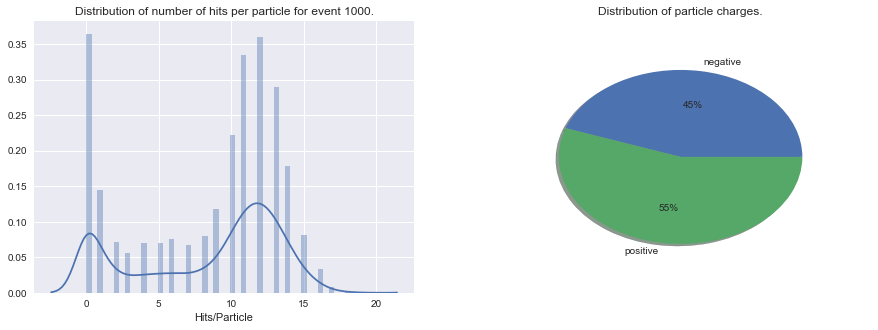

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(particles.nhits.values, axlabel='Hits/Particle', bins=50)
plt.title('Distribution of number of hits per particle for event 1000.')
plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        labels=['negative', 'positive'],
        autopct='%.0f%%',
        shadow=True,
        radius=0.8)
plt.title('Distribution of particle charges.')
plt.show()

### Initial Position and Momentum
Let's now take a look at the initial position of the particles around the global coordinates origin $(x, y)=(0,0)$, as shown in the figure below.

The initial position distribution is more concentrated around the origin (less variance) than it's hit position (shown above under the Hits Data section).  As the particles hit the detection surface they tend to scatter as shown in the particle trajectory plot at the end of this notebook.

The colors here show the number of hits for each particle.

### 初期ポジションとモメンタム
下の図に示すように、グローバル座標原点$（x、y）=（0,0）$の周りの粒子の初期位置を見てみましょう。

初期の位置分布は、ヒット位置よりも原点の周りに集中しています（ヒットデータセクションの上に表示されています）。 粒子が検出表面に衝突すると、粒子はこのノートブックの終わりの粒子軌跡プロットに示すように散乱する傾向があります。

ここの色は、各パーティクルのヒット数を示します。

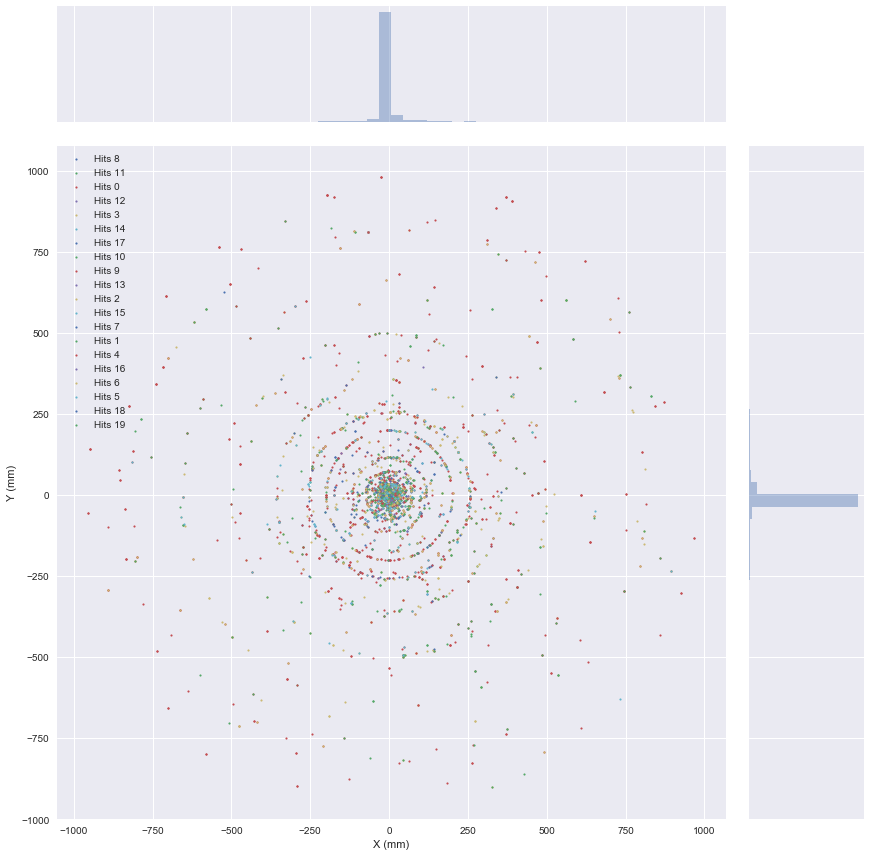

In [26]:
g = sns.jointplot(particles.vx, particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vx, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

* ![](http://)![](http://)And here is the initial position of the particles in a $z$, $y$ view.  Colors show number of hits.

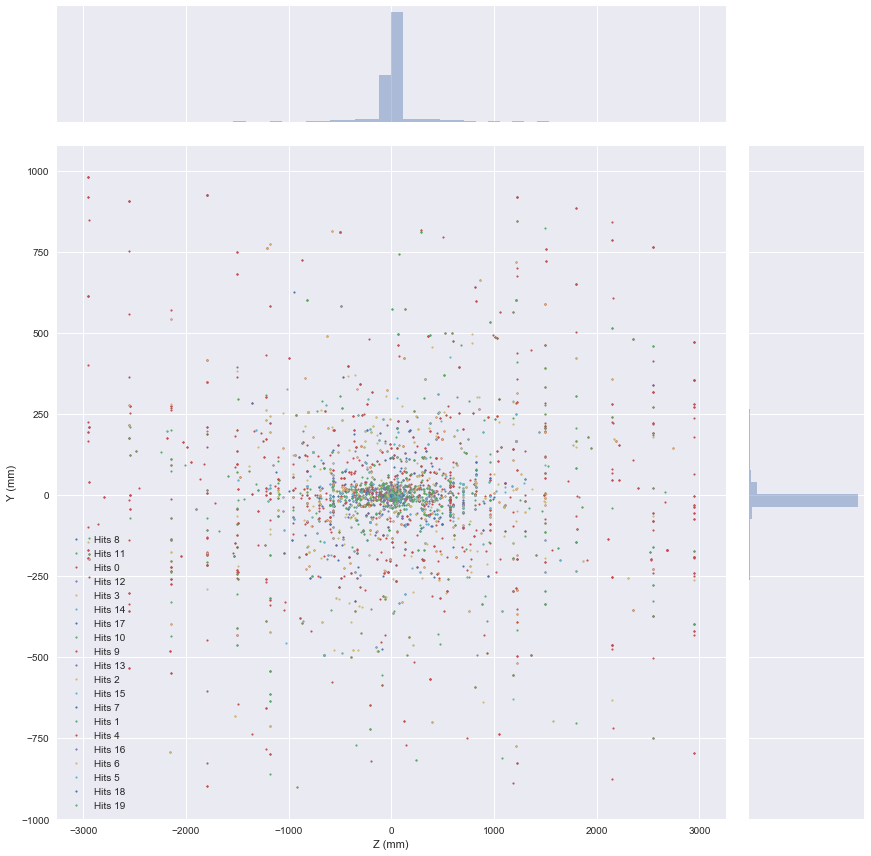

In [27]:
g = sns.jointplot(particles.vz, particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vz, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

And this is what they look like in 3D

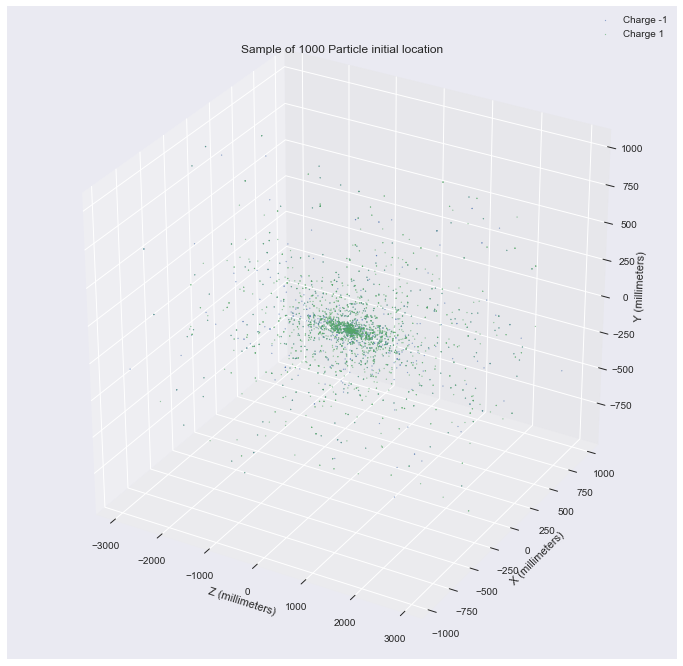

In [28]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for charge in [-1, 1]:
    q = particles[particles.q == charge]
    ax.scatter(q.vz, q.vx, q.vy, s=1, label='Charge {}'.format(charge), alpha=0.5)
ax.set_title('Sample of 1000 Particle initial location')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

## Pair plot
Let's now take a look at the relationship between different pair combinations of the particles' variables.  Again, the colors represent the number of hits.

There is no large skew in the distribution of the number of hits over other variables.  It looks like the particles are targetted towards the global origin $(x,y)=(0,0)$ and are evenly distributed around it.

In [29]:
p_sample = particles.sample(8000)
sns.pairplot(p_sample, vars=['particle_id', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'nhits'], hue='nhits', size=8)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
